In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, join, vstack, hstack, Column

In [61]:
t1 = Table.read('1529675828990A.csv') # Isaacson 2010

t2 = Table.read('1529675935385A.csv') # Brewer Spocs 2016

t3 = Table.read('1529678217618A.csv') # Duncan 1991

t4 = Table.read('1529762909013A.csv') # Wright 2004

t5 = Table.read('1529763766793A.csv') # Pace 2013

In [62]:
distance_1 = 1/(t1['parallax']/1000)
abs_mag_1 = t1['phot_g_mean_mag'] - 5*(np.log10(distance_1) - 1)

distance_2 = 1/(t2['parallax']/1000)
abs_mag_2 = t2['phot_g_mean_mag'] - 5*(np.log10(distance_2) - 1)

distance_3 = 1/(t3['parallax']/1000)
abs_mag_3 = t3['phot_g_mean_mag'] - 5*(np.log10(distance_3) - 1)

distance_4 = 1/(t4['parallax']/1000)
abs_mag_4 = t4['phot_g_mean_mag'] - 5*(np.log10(distance_4) - 1)

distance_5 = 1/(t5['parallax']/1000)
abs_mag_5 = t5['phot_g_mean_mag'] - 5*(np.log10(distance_5) - 1)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


In [63]:
sigma_sb = 5.67051e-5 # http://www.astro.wisc.edu/~dolan/constants.html
import astropy.units as u

def c_cf(b_minus_v):
    # Mittag 2013, eq. 7 (main sequence):
    return 10**(0.25*b_minus_v**3 - 1.33*b_minus_v**2 + 0.43*b_minus_v + 0.24)

# alpha_apo = np.loadtxt('calibration_constants/calibrated_c1.txt')[0]
alpha_mwo = 19.2
alpha_keck = 32.510

def scriptf_hk(s, b_minus_v, t_eff, alpha_ratio=1): #alpha_mwo/alpha_apo):
    # Mittag 2013
    K = 10**(6.086 - 0.2088*b_minus_v + 0.3564*b_minus_v**2 - 0.002*b_minus_v**3) / alpha_ratio # Eqn. 12
    F_hk = c_cf(b_minus_v) * t_eff**4 * 1e-14 * s # eqn 9
    return K * F_hk # eqn 10

def scriptf_hkphot(b_minus_v):
    # Mittag 2013 eqn 20:
    return 10**(7.49 - 2.06 * b_minus_v)

def rprime_hk(s, b_minus_v, t_eff, alpha_ratio=1):
    # Mittag 2013 eqn 24
    return (scriptf_hk(s, b_minus_v, t_eff, alpha_ratio=alpha_ratio) - scriptf_hkphot(b_minus_v)) / (sigma_sb * t_eff**4)

def log_rprime_hk(s, b_minus_v, t_eff, alpha_ratio=1):
    return np.log10(rprime_hk(s, b_minus_v, t_eff, alpha_ratio=alpha_ratio))

def bv_2_teff(b_minus_v):
    # Mittag eqn. 3
    return 10**(3.981 - 0.4728*b_minus_v + 0.2434*b_minus_v**2 - 0.0620*b_minus_v**3)

b_minus_v = (t3['Bmag'] - t3['Vmag']).data
t_eff = bv_2_teff(b_minus_v)
s = t3['Smean'].data

logrprime = log_rprime_hk(s, b_minus_v, t_eff)

t3.add_column(Column(logrprime, 'logRHK'))

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log10


In [64]:
b_minus_v = (t3['Bmag'] - t3['Vmag']).data
t_eff = bv_2_teff(b_minus_v)
s = t3['Smean'].data

logrprime = log_rprime_hk(s, b_minus_v, t_eff)

t3.add_column(Column(logrprime, 'logRHK'))

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log10


ValueError: Duplicate column names

In [181]:
bp_rp = np.hstack([list(t1['bp_rp'].data.data), list(t2['bp_rp'].data.data), 
                   list(t3['bp_rp'].data.data), list(t4['bp_rp'].data.data),
                   list(t5['bp_rp'].data.data)])
absmag = np.hstack([abs_mag_1.data.data, abs_mag_2.data.data, 
                    abs_mag_3.data.data, abs_mag_4.data.data, 
                    abs_mag_5.data.data])
logrhk = np.hstack([list(t1['logRhk'].data.data), list(t2['logRHK'].data.data), 
                    list(t3['logRHK'].data.data), list(t4["log(R'HK)"].data.data),
                    np.mean([t5['logRmin'], t5['logRmax']], axis=0)]) #list(t5['logRMW'].data.data)])

sourceids = np.hstack([list(t1['source_id'].data.data), list(t2['source_id'].data.data), 
                   list(t3['source_id'].data.data), list(t4['source_id'].data.data),
                   list(t5['source_id'].data.data)])

names = np.hstack([list(t1['Name'].data.data), list(t2['Name'].data.data), 
                   list(t3['SName'].data.data), list(t4['SimbadName'].data.data),
                   list(t5['HD'].data.data)])

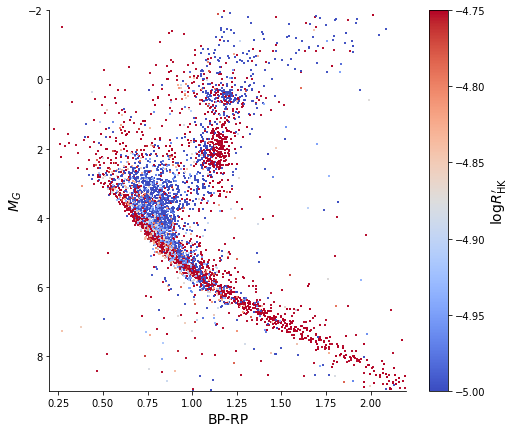

In [73]:
fig, ax = plt.subplots(figsize=(8, 7))
vmin, vmax = -5, -4.75
# vmin, vmax = -5, -4
cmap = plt.cm.coolwarm #plt.cm.viridis_r
cax = plt.scatter(bp_rp, absmag, marker=',', s=1, c=logrhk, vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)

cbar = plt.colorbar(cax)
cbar.set_label('$\log R^\prime_\mathrm{HK}$', fontsize=14)
plt.gca().invert_yaxis()
# plt.xlim([0.5, 1.5]) # MS
# plt.ylim([7, 3.5])

plt.xlim([0.2, 2.2]) # all
plt.ylim([9, -2])

for s in ['right', 'top']:
    ax.spines[s].set_visible(False)

plt.xlabel('BP-RP', fontsize=14)
plt.ylabel('$M_G$', fontsize=14)
fig.savefig('ms.pdf', bbox_inches='tight')
fig.savefig('ms.png', dpi=200, bbox_inches='tight')

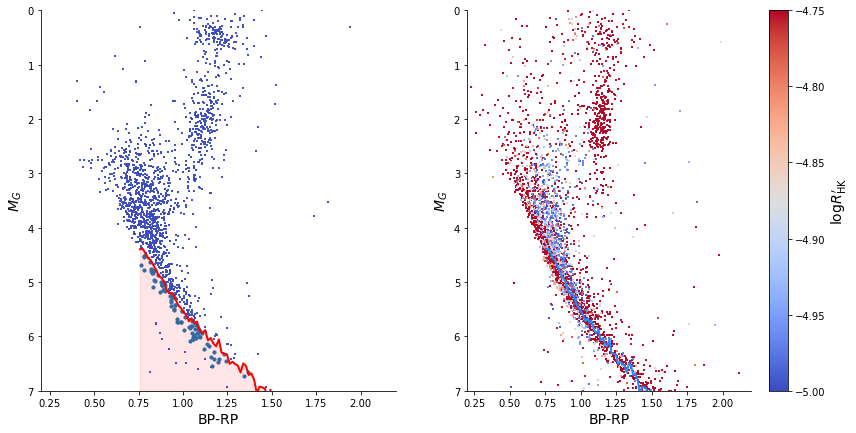

In [261]:
from scipy.stats import binned_statistic

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
lower_limit = -5

vmin, vmax = lower_limit, -4.75
cmap = plt.cm.coolwarm

inactive = (logrhk < lower_limit) #& (bp_rp != 0)
active = np.logical_not(inactive) #& (bp_rp != 0)

cax = ax[0].scatter(bp_rp[inactive], absmag[inactive], marker=',', s=1, c=logrhk[inactive], vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)


xrange = np.linspace(0.75, 1.5, 50)
bincenters = 0.5 * (xrange[1:] + xrange[:-1])
bs = binned_statistic(bp_rp[active][absmag[active] > 4], absmag[active][absmag[active] >  4], statistic='median', bins=xrange)

cax = ax[1].scatter(bp_rp[active], absmag[active], marker=',', s=1, c=logrhk[active], vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)

color_to_mag = lambda color: np.interp(color, bincenters, bs.statistic)

inactive_dwarf = inactive & (absmag > color_to_mag(bp_rp)) & (abs(absmag - color_to_mag(bp_rp)) < 0.5)
ax[0].scatter(bp_rp[inactive_dwarf], absmag[inactive_dwarf], s=10)

ax[0].plot(bincenters, bs.statistic, color='r', lw=2)

ax[1].plot(bincenters, bs.statistic, color='DodgerBlue', lw=2)

ax[0].fill_between(bincenters, bs.statistic, 7, color='r', alpha=0.1)

cbar = plt.colorbar(cax)
cbar.set_label('$\log R^\prime_\mathrm{HK}$', fontsize=14)
plt.gca().invert_yaxis()

for axis in ax:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.set_xlim([0.2, 2.2]) # all
    axis.set_ylim([7, 0])
    
    axis.set_xlabel('BP-RP', fontsize=14)
    axis.set_ylabel('$M_G$', fontsize=14)

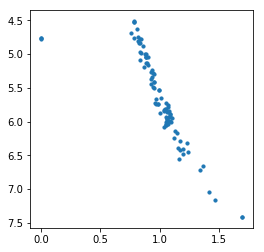

In [262]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(bp_rp[inactive_dwarf], absmag[inactive_dwarf], s=10)
ax.invert_yaxis()

In [263]:
sourceids[inactive_dwarf], names[inactive_dwarf]

(array([ 104453918172129792,  474648763011926272, 3712538708114516736,
        3712538811193759744, 1648568843759668480, 4610177733290768896,
        2028419118702895616, 1833199729671740800, 2105343799713595904,
        2131133261560058496, 2100417162990276608, 2102899692744736640,
        2080290400786846336, 2786053067672564736, 3811032513054107648,
        3896271842760486272, 3794479262419500160, 3626268998574790656,
        2103579397088495616, 2106303505865370752, 2105435544515167232,
        2131216137248338304, 2102454253097554304, 2127941757262806656,
        2133074586777433344, 2019164662448947200, 1999551612692096128,
         312804946364548096, 5025366311917644416, 5168359139138674816,
         474648763011926272, 3319126988068404096, 1295128528909162496,
         602079652404802688, 3712538708114516736, 1253199546336180864,
        1648568843759668480, 2019164662448947200, 1833199729671740800,
        6597043794989308928, 1279694100073900416, 2430911155498132736,
      

* KIC-7107778 is a pair of binary subdwarf solar twins
* KIC-8311864 (KOI-7016) is Kepler-452: period = 43
* Kepler-104 (KOI-111) few planets: period = 45
* Kepler-97 (KOI-292) few planets: period = 46 really good solar analog

In [210]:
from astropy.io import fits

f = fits.open('cks-k07016_bj207.71.fits', ext=1)

In [211]:
wavelengths = f[2].data
fluxes = f[0].data

(0, 1)

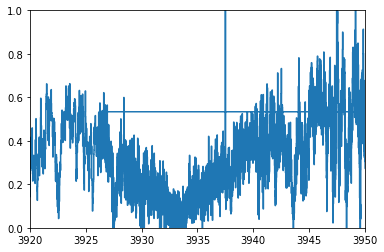

In [220]:
norm_wavelengths = []
norm_fluxes = []

for w, f in zip(wavelengths, fluxes):
    norm_wavelengths.extend(w.tolist())
    norm_fluxes.extend((f/np.percentile(f, 99)).tolist())

plt.plot(norm_wavelengths, norm_fluxes, ls='steps')
plt.xlim([3920, 3950])
plt.ylim([0, 1])

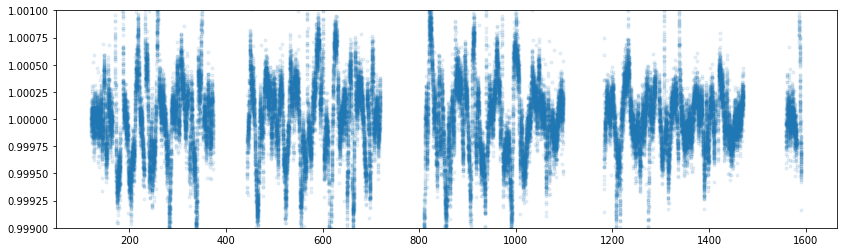

48.0801739543


(0, 150)

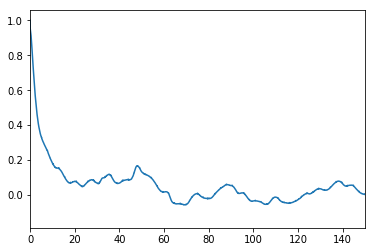

In [264]:
import kplr
client = kplr.API()

koi = client.koi(292.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Loop over the datasets and read in the data.
time, flux, ferr, quality = [], [], [], []
for lc in lcs:
    with lc.open() as f:
        # The lightcurve data are in the first FITS HDU.
        hdu_data = f[1].data
        t = hdu_data["time"]
        f = hdu_data["sap_flux"]/np.nanmax(hdu_data["sap_flux"])
        not_nan = np.logical_not(np.isnan(t) | np.isnan(f))
        fit = f[not_nan]/np.polyval(np.polyfit(t[not_nan], f[not_nan], 3), t[not_nan])
        time.append(t[not_nan])
        flux.append(fit)
        ferr.append(hdu_data["sap_flux_err"])
        quality.append(hdu_data["sap_quality"])
        
time = np.hstack(time)
flux = np.hstack(flux)

plt.figure(figsize=(14, 4))
plt.plot(time, flux, '.', alpha=0.1)
plt.ylim([0.999, 1.001])
plt.show()

from interpacf import interpolated_acf, dominant_period
lag, acf = interpolated_acf(time, flux - flux.mean())
print(dominant_period(lag, acf))
plt.plot(lag, acf/acf.max())
plt.xlim([0, 150])

In [269]:
from gatspy import periodic

model = periodic.LombScargle(fit_period=True)
model.optimizer.period_range = (10, 60)
model.fit(time, flux)
model.best_period

Finding optimal frequency:
 - Estimated peak width = 0.00427
 - Using 5 steps per peak; omega_step = 0.000855
 - User-specified period range:  10 to 60
 - Computing periods at 614 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


46.238475038593158